### SML-IDL project submission

- This file contains only implementation the full code is at [GitHub](https://github.com/varshil009/LoadForecast-UKPN)
- Please read how to use this notebooks from ***Readme*** file from GitHub 
- we uploaded sample of dataset that was used for training there.

Submitted by :
1. Mrugank Gandhi 24070149007
2. Varshilkumar Prajapati 24070149020
3. Jay Thakkar 24070149026

In [69]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from TAT import prepare_data, TimeAugmentedTransformer, TimeAugmentedEncoding, PositionalEncoding, MultiHeadAttention
from TAT import FeedForward, EncoderLayer, DecoderLayer, TimeSeriesDataset, train_transformer

from errors import error_df

In [18]:
df = pd.read_csv(r"C:\Users\Varshil\Downloads\super_grid_2021_22 (1).csv")

In [19]:
df.head()

,Unnamed: 0,Date,GSP,SGT,Voltage_Min,Voltage_Max,Voltage_Avg,ActivePower_Min,ActivePower_Max,ActivePower_Avg,ReActivePower_Min,ReActivePower_Max,ReActivePower_Avg,Current_Min,Current_Max,Current_Avg
0,1020819,2021-01-25 23:30:00+00:00,BARKING WEST (LPN),SGT1A,33.33,33.33,33.33,19.60,20.14,19.69,2.0,2.48,2.08,338.00,341.89,338.21
1,1020822,2021-01-25 22:30:00+00:00,BARKING WEST (LPN),SGT1A,33.32,33.33,33.33,20.79,22.41,21.72,2.5,2.90,2.61,364.66,388.26,377.02
2,1020825,2021-01-25 21:00:00+00:00,BARKING WEST (LPN),SGT1A,32.91,32.91,32.91,23.80,25.01,24.48,3.6,4.40,4.00,431.00,442.12,432.68
3,1020828,2021-01-25 20:00:00+00:00,BARKING WEST (LPN),SGT1A,32.84,32.91,32.88,25.82,26.41,26.04,4.1,4.60,4.23,460.21,470.18,467.56
4,1020831,2021-01-25 17:30:00+00:00,BARKING WEST (LPN),SGT1A,32.80,32.80,32.80,26.02,26.65,26.28,3.7,4.62,4.10,459.98,472.53,467.53


In [4]:
df.shape

(17520, 9)

In [23]:
df['Date'] = pd.to_datetime(df.Date)

In [63]:
train_df = df[(df['Date'] < "2022-03-01") & (df['Date'] >= "2021-08-01")]
test_df = df[(df['Date'] <= '2022-03-15') & (df['Date'] > "2022-02-28")]

In [64]:
train_df.shape, test_df.shape

((10176, 16), (720, 16))

In [66]:
train_df.sort_values(by = 'Date', inplace= True)
test_df.sort_values(by = 'Date', inplace= True)

C:\Users\Varshil\AppData\Local\Temp\ipykernel_34144\3114533435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by = 'Date', inplace= True)
C:\Users\Varshil\AppData\Local\Temp\ipykernel_34144\3114533435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.sort_values(by = 'Date', inplace= True)


In [70]:
# Model parameters
seq_length = 48  # Look at past 48 timesteps look back a 24 hours
prediction_horizon = 1  # Predict next timestep
batch_size = 336 # whole week goes as batch
input_dim = 1  # Single feature (ActivePower_Avg)
output_dim = 1  # Predicting single value

# Prepare data
train_loader, dataset = prepare_data(
    df = train_df,
    target = train_df.ActivePower_Avg,
    seq_length = seq_length,
    prediction_horizon = prediction_horizon,
    batch_size = batch_size
)

# Create model
model = TimeAugmentedTransformer(
    input_dim = input_dim,
    output_dim = output_dim,
    d_model = 64,
    num_heads = 4,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    d_ff = 128,
    dropout = 0.1
)

In [71]:
# Train model
train_transformer(model, train_loader, num_epochs = 100)

Epoch [10/100], Loss: 0.0465
Epoch [20/100], Loss: 0.0134
Epoch [30/100], Loss: 0.0136
Epoch [40/100], Loss: 0.0069
Epoch [50/100], Loss: 0.0061
Epoch [60/100], Loss: 0.0033
Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0033
Epoch [90/100], Loss: 0.0016
Epoch [100/100], Loss: 0.0016


In [72]:
# saved models TAT, TAT2, TAT2_weekly
torch.save(model, 'TAT3_6month_trained_weekly.pth')
"""model = TimeAugmentedTransformer(1, 1)
model = torch.load("TAT2_weekly.pth", map_location = torch.device('cpu')) # Put the model into evaluation model
model.eval()
print("Loaded")"""

'model = TimeAugmentedTransformer(1, 1)\nmodel = torch.load("TAT2_weekly.pth", map_location = torch.device(\'cpu\')) # Put the model into evaluation model\nmodel.eval()\nprint("Loaded")'

In [73]:
test_loader, dataset = prepare_data(
    df = test_df,
    target = test_df.ActivePower_Avg,
    seq_length = seq_length,
    prediction_horizon = 1,
    batch_size = batch_size
)

In [74]:

tat_pred = []
# Make predictions
model.eval()
with torch.no_grad():
    for _ in range(test_df.shape[0] // batch_size):
        # Get a batch of data
        batch = next(iter(test_loader))

        # Make prediction
        prediction = model(batch['src'], batch['time_values'], batch['tgt'])
        prediction = dataset.inverse_transform(prediction.flatten().reshape(-1, 1))
        tat_pred += list(prediction.flatten())

In [75]:
len(tat_pred)

672

In [76]:
title = {'family': 'serif', 'color':  'darkred', 'weight': 'bold', 'size': 15}
label = {'family': 'sans serif', 'color':  'darkred', 'weight': 'bold', 'size': 16}

In [77]:
test_df['ActivePower_Avg'][48:672+48].shape

(672,)

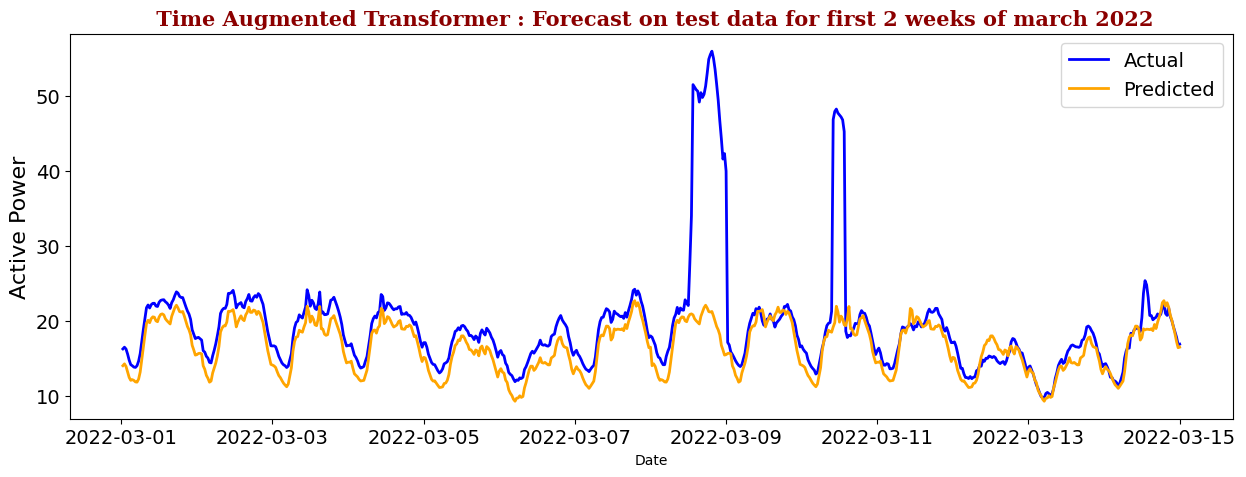

In [78]:
plt.figure(figsize=(15, 5))
plt.title(" Time Augmented Transformer : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'][48:672+48], y = test_df['ActivePower_Avg'][48:672+48], 
             label='Actual', color='blue', linewidth = 2.,  markersize=5)

# Plot predicted values
sns.lineplot(x = test_df['Date'][48:672+48], y = tat_pred, 
             label='Predicted', color='orange', linewidth = 2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

In [79]:
len(tat_pred)

672

In [80]:
erros_tat = error_df("TAT", test_df.ActivePower_Avg[48:672+48], np.array(tat_pred))
erros_tat

,model,r2,mse,rmse,mape
0,TAT,0.201305,42.667234,6.532016,12.16


In [81]:
from nn_forecast import NNf, prepare_data, evaluate, TimeSeriesDataset, train, make_sequential_predictions

In [91]:
df_nn = df[(df.Date >= "2021-08-01") & (df.Date <= "2022-03-15")]
df_nn.sort_values(by = "Date", inplace = True)
data = np.array(df_nn.ActivePower_Avg)

C:\Users\Varshil\AppData\Local\Temp\ipykernel_34144\277122981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nn.sort_values(by = "Date", inplace = True)


In [93]:
# Step 1: Prepare data
data_config = prepare_data(
    data=np.array(df_nn.ActivePower_Avg),
    n_lags=48,
    val_size=672,
    test_size=672,
    batch_size=32
)

# Step 2: Initialize model
model = NNf(input_dim=48, hidden_dims=[32, 16])

# Step 3: Train model
train_losses, val_losses = train(
    model = model,
    train_loader = data_config['train_loader'],
    val_loader = data_config['val_loader'],
    epochs=100
)

# Step 4: Evaluate model and make future predictions
results = evaluate(
    model = model,
    test_loader = data_config['test_loader'],
    scaler = data_config['scaler'],
    #last_sequence=data_config['last_sequence'],
    #forecast_horizon=672  # Number of future steps to predict
)

# Access results
ann_pred = results['predictions']
actuals = results['actuals']
metrics = results['metrics']

Epoch 10: Train Loss = 0.0022, Val Loss = 0.0010
Epoch 20: Train Loss = 0.0017, Val Loss = 0.0008
Epoch 30: Train Loss = 0.0017, Val Loss = 0.0006
Epoch 40: Train Loss = 0.0017, Val Loss = 0.0006
Epoch 50: Train Loss = 0.0016, Val Loss = 0.0006
Epoch 60: Train Loss = 0.0016, Val Loss = 0.0006
Epoch 70: Train Loss = 0.0016, Val Loss = 0.0006
Epoch 80: Train Loss = 0.0016, Val Loss = 0.0005
Epoch 90: Train Loss = 0.0015, Val Loss = 0.0004
Epoch 100: Train Loss = 0.0015, Val Loss = 0.0006


In [20]:
!pip install torchsummary

    sys-platform (=="win32") ; extra == 'angle'
                 ~^

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [94]:
from torchsummary import summary

def model_summary(model, input_size):
    """
    Generate a summary of the model architecture.
    
    Args:
        model: PyTorch model.
        input_size: Tuple representing the size of the input (excluding batch size).
    
    Returns:
        A formatted table summarizing the model architecture.
    """
    print(f"{'=' * 30} Model Summary {'=' * 30}\n")
    summary(model, input_size)
    print(f"\n{'=' * 75}\n")

# Example usage:
# Assuming your model is initialized as `model` and input size is (12,):
model_summary(model, input_size=(48,))

============================== Model Summary ==============================

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           1,568
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
              ReLU-5                   [-1, 16]               0
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 1]              17
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------




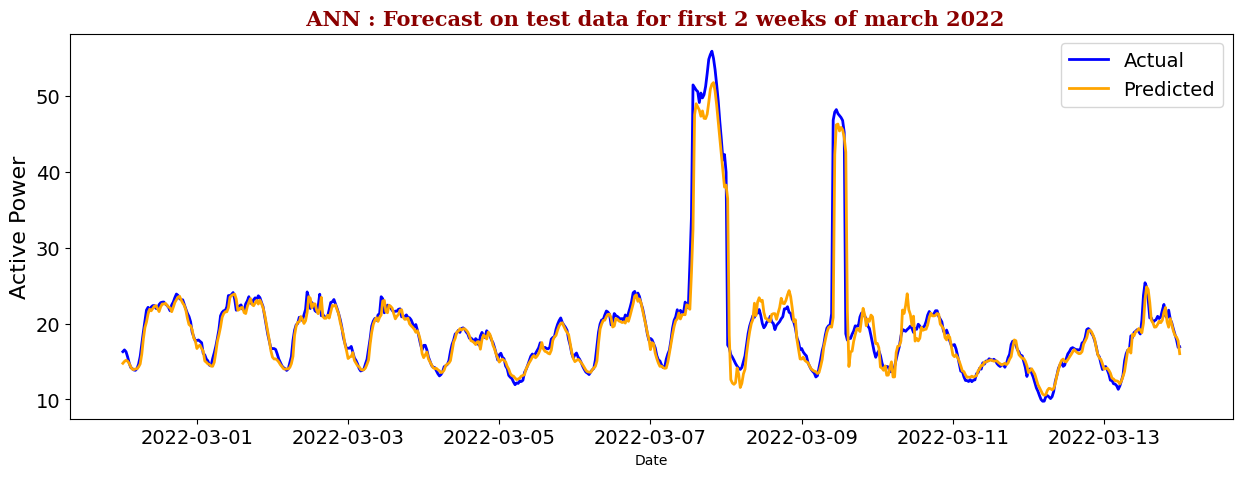

'plt.figure(figsize = (15, 5))\nsns.lineplot(x = test_df.Date, y = test_df.ActivePower_Avg, label=\'Actual\', color = "skyblue")\nsns.lineplot(x = test_df.Date, y = predictions, label=\'Predicted\', color = \'orange\')\nplt.legend()\nplt.title(\'NN Predictions vs Actuals\')'

In [97]:
plt.figure(figsize=(15, 5))
plt.title(" ANN : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'][:672], y=actuals, 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'][:672], y=ann_pred, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

"""plt.figure(figsize = (15, 5))
sns.lineplot(x = test_df.Date, y = test_df.ActivePower_Avg, label='Actual', color = "skyblue")
sns.lineplot(x = test_df.Date, y = predictions, label='Predicted', color = 'orange')
plt.legend()
plt.title('NN Predictions vs Actuals')"""

In [96]:
erros_nn = error_df("nn", actuals, ann_pred)

In [87]:
erros_nn

,model,r2,mse,rmse,mape
0,nn,0.898278,6.740342,2.596217,6.37


In [98]:
import json

with open(r"C:\Users\Varshil\Downloads\lstms.json", "r") as json_file:
    # Step 2: Load the data from the file
    data = json.load(json_file)

# Accessing specific elements
lstm_preds = data["preds"] 

In [107]:
len(lstm_preds)

673

In [99]:
bagg = (np.array(tat_pred) * (1 - 0.2138) + np.array(ann_pred) * ( 1 - 0.0517) + np.array(lstm_preds[:-1]) * (1 - 0.0363)) / 3

In [100]:
error_df("bagging TAT & ANN", actuals, bagg)

,model,r2,mse,rmse,mape
0,bagging TAT & ANN,0.672164,17.513384,4.1849,13.28


ValueError: array length 672 does not match index length 720

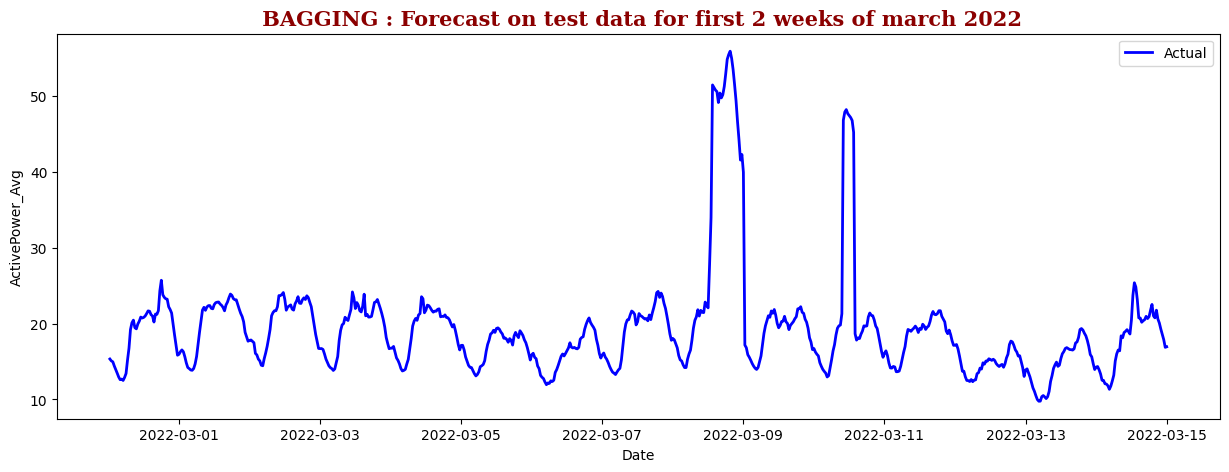

In [101]:
plt.figure(figsize=(15, 5))
plt.title(" BAGGING : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'], y=test_df['ActivePower_Avg'], 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'], y=bagg, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

ValueError: array length 672 does not match index length 720

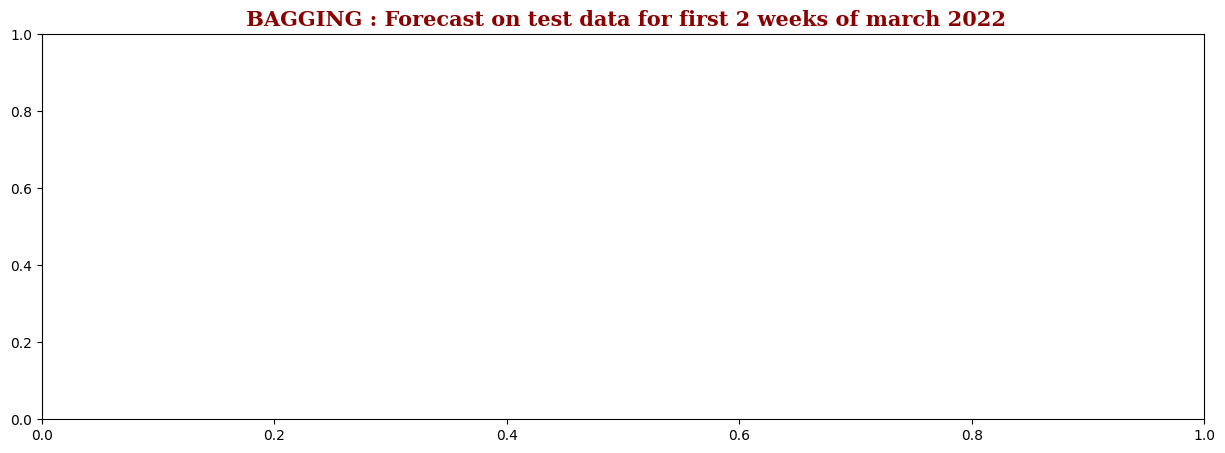

In [108]:

# Calculate weights based on MAPE (lower MAPE -> higher weight)
w_ann = 1 - (5.17 / 100)
w_tat = 1 - (12.16 / 100)
w_lstm = 1 - (3.63 / 100)

# Calculate the final weighted average prediction
weighted_sum = (np.array(ann_pred) * w_ann + np.array(tat_pred) * w_tat + np.array(lstm_preds[:-1]) * w_lstm)
total_weight = (w_ann + w_tat + w_lstm)

# Final ensemble prediction
final_pred = weighted_sum / total_weight

plt.figure(figsize=(15, 5))
plt.title(" BAGGING : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'], y=actuals, 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'], y=final_pred, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

In [31]:
error_df("bagging", actuals, final_pred)

,model,r2,mse,rmse,mape
0,bagging,0.74674,13.531643,3.678538,7.83


In [105]:
test_df.shape

(720, 16)

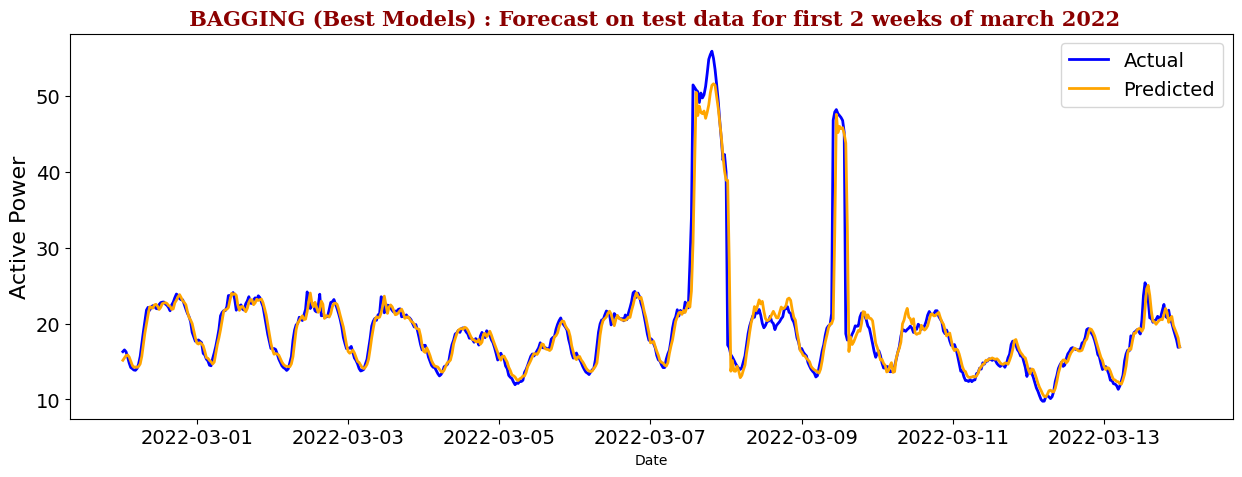

In [112]:

# Calculate weights based on MAPE (lower MAPE -> higher weight)
w_ann = 1 - (6.37 / 100)
w_lstm = 1 - (3.34 / 100)

# Calculate the final weighted average prediction
weighted_sum = (np.array(ann_pred) * w_ann +  np.array(lstm_preds[:-1]) * w_lstm)
total_weight = (w_ann + w_lstm)

# Final ensemble prediction
final_pred = weighted_sum / total_weight

plt.figure(figsize=(15, 5))
plt.title(" BAGGING (Best Models) : Forecast on test data for first 2 weeks of march 2022", fontdict = title)
sns.lineplot(x=test_df['Date'][:672], y=actuals, 
             label='Actual', color='blue', linewidth=2.,  markersize=5)

# Plot predicted values
sns.lineplot(x=test_df['Date'][:672], y=final_pred, 
             label='Predicted', color='orange', linewidth=2., markersize=5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Active Power", fontsize = 16)
plt.legend(fontsize='14') 
plt.show()

In [113]:
error_df("weighted bagging ensemble : best models", actuals , final_pred)

,model,r2,mse,rmse,mape
0,weighted bagging ensemble : best models,0.895825,5.565173,2.359062,4.76
